In [1]:
import os
import sys
os.chdir('..')
sys.path.append(os.getcwd())

In [2]:
import torch
from Models.pretrain import *
from Models.cPB import cPB
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=UserWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='torch.storage')

# SINE datasets


## CONFIGURATION:


In [19]:
base_model = 'GRU'
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=10
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
input_size=2
iteration=1
mask_init='uniform'
dataset='SINE'
dataset_name = "sine_rw10_mode5_extended_16-16_1234"
Pretrain_task = '1'
df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
pretrain_model_addr=f'Performance/Pretrain/{base_model}/{dataset}/After/{dataset}-Task_{Pretrain_task}-{base_model}-pretrain-hidden{hidden_size}-epoch10_iter{iteration}.pickle'
mask_weights=[] #if we have initial masks then reload it here


mask_option = 'SUM'
model_type = 'cPB'
batch_first = True
low_rank = False

## Executable code:


list of accuracies that used for evaluating and selecting the models =  [0.78109375]
list of kappa values that used for evaluating and selecting the models =  [0.57740737]
index of selcted mask for this task 0
All batches Accuracy=  0.9267140539617486
All batches cohen kappa=  0.8529903389986788
list of accuracies that used for evaluating and selecting the models =  [0.79734375 0.806875  ]
list of kappa values that used for evaluating and selecting the models =  [0.59955777 0.61673782]
index of selcted mask for this task 1
All batches Accuracy=  0.8380122950819672
All batches cohen kappa=  0.6738431547193335
list of accuracies that used for evaluating and selecting the models =  [0.838125  0.8140625 0.8190625]
list of kappa values that used for evaluating and selecting the models =  [0.67655099 0.62701186 0.63906306]
index of selcted mask for this task 0
All batches Accuracy=  0.9238089139344262
All batches cohen kappa=  0.8455222361196911
list of accuracies that used for evaluating an

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:418: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


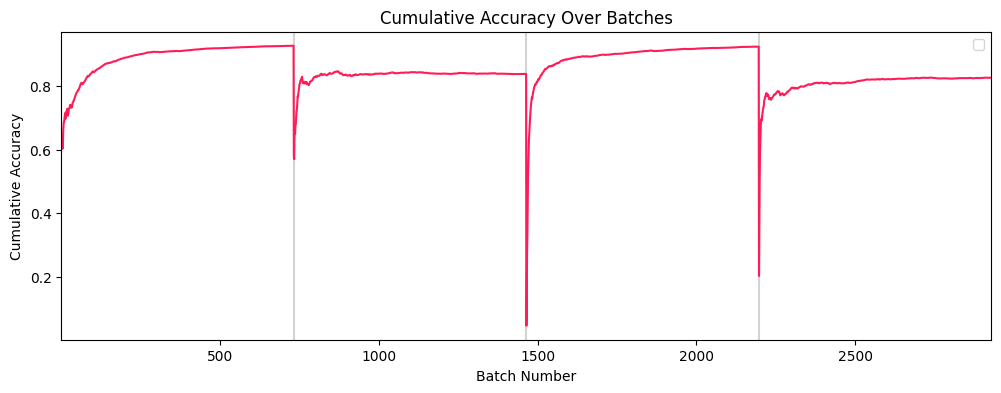

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:435: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


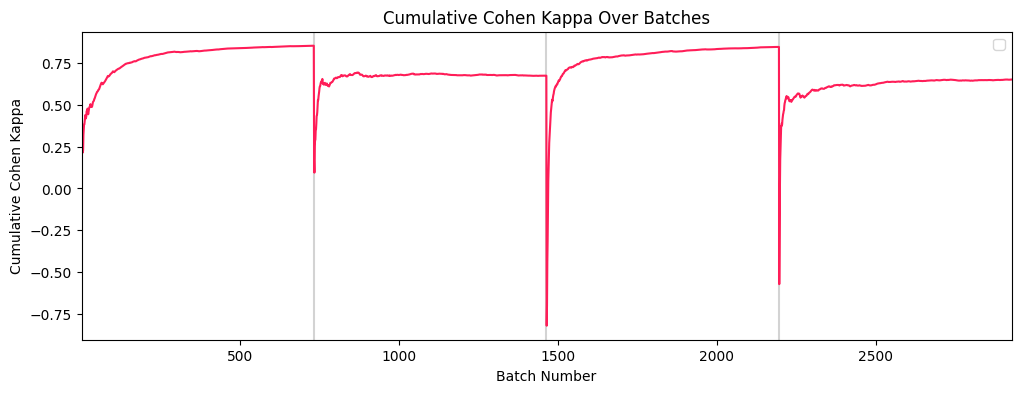

In [20]:
model=cPB(lr = lr ,hidden_size = hidden_size, seq_len = seq_len,base_model = base_model, pretrain_model_addr = pretrain_model_addr,
           mask_weights = mask_weights, mask_init = mask_init, number_of_tasks = number_of_tasks, epoch_size = epoch_size,
           input_size = input_size, mask_option = mask_option, model_type = model_type, batch_first = batch_first, low_rank = low_rank)


for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index,task,mask_selection=True)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column(task)
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.performance, file)

file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}_selectedMask.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.selected_mask_index, file)


file_path=f'Performance/Final Models/{model_type}/{base_model}/{dataset}/{dataset}-{base_model}-pretrain-hidden{hidden_size}-epoch10-Mask_{mask_option}-itter{iteration}.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(model.all_models_weight, file)

hidden_size 50
list of accuracies that used for evaluating and selecting the models =  [0.728125]
list of kappa values that used for evaluating and selecting the models =  [0.46243829]
index of selcted mask for this task 0
All batches Accuracy=  0.8657018442622951
All batches cohen kappa=  0.7300263510945716
list of accuracies that used for evaluating and selecting the models =  [0.754375  0.7146875]
list of kappa values that used for evaluating and selecting the models =  [0.50823399 0.43696621]
index of selcted mask for this task 0
All batches Accuracy=  0.8229465505464482
All batches cohen kappa=  0.6445585491512317
list of accuracies that used for evaluating and selecting the models =  [0.77078125 0.7653125  0.75734375]
list of kappa values that used for evaluating and selecting the models =  [0.5471157  0.53087247 0.51839529]
index of selcted mask for this task 0
All batches Accuracy=  0.892155481557377
All batches cohen kappa=  0.7828171402648539
list of accuracies that used for 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:272: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


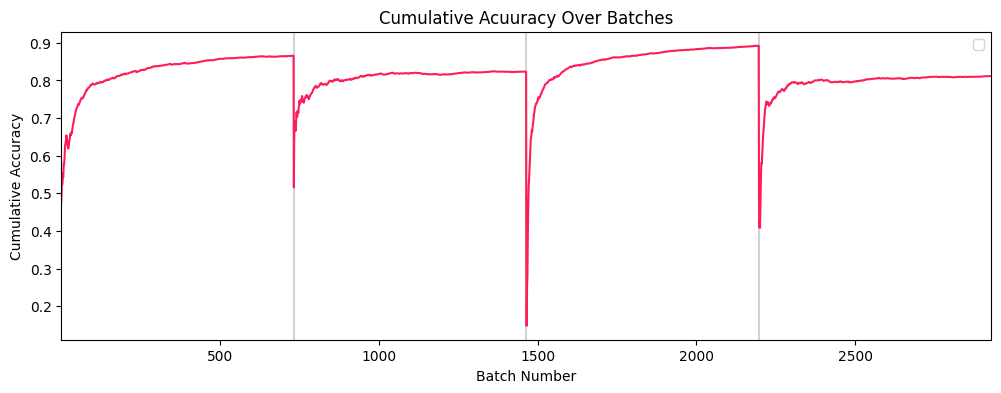

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:289: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


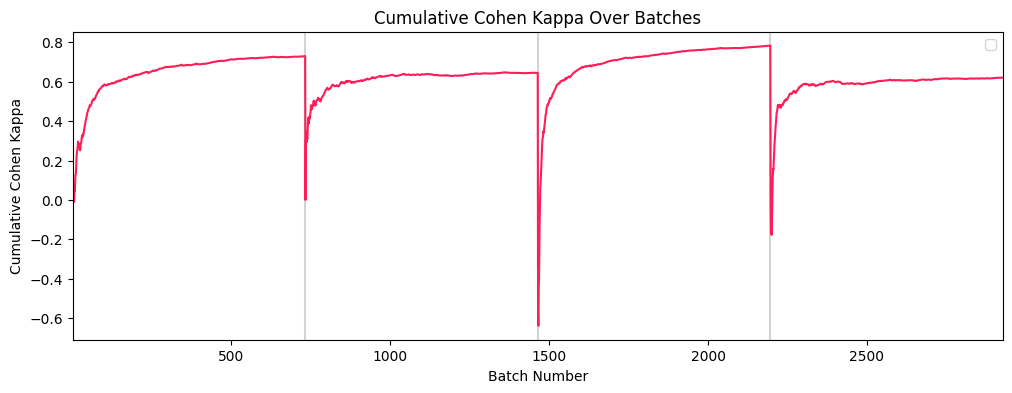

In [4]:
model=cPB(lr = lr ,hidden_size = hidden_size, seq_len = seq_len,base_model = base_model, pretrain_model_addr = pretrain_model_addr,
           mask_weights = mask_weights, mask_init = mask_init, number_of_tasks = number_of_tasks, epoch_size = epoch_size,
           input_size = input_size, mask_option = mask_option, model_type = model_type, batch_first = batch_first)


for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index,task,mask_selection=True)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column(task)
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


file_path = f'Performance/Results/cPB/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.performance, file)

file_path = f'Performance/Results/cPB/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10_iter{iteration}_selectedMask.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model.selected_mask_index, file)


# Weather datasets


## CONFIGURATION:


In [27]:
base_model = 'GRU'
batch_size = 128
hidden_size = 50
seq_len = 11
epoch_size=10
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
input_size=4
iteration=3
mask_init='uniform'
dataset='Weather'
dataset_name = "weather_st124_1conf"
Pretrain_task = '1'

df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
pretrain_model_addr=f'Performance/Pretrain/{base_model}/{dataset}/After/{dataset}-{base_model}-pretrain-hidden{hidden_size}-epoch10_itter{iteration}.pickle'
mask_weights=[] #if we have initial masks then reload it here

mask_option = 'DOT'
model_type = 'cPB'
batch_first = True
low_rank = False



## Executable code:


list of accuracies that used for evaluating and selecting the models =  [0.84515625]
list of kappa values that used for evaluating and selecting the models =  [0.69034329]
index of selcted mask for this task 0
All batches Accuracy=  0.8781213981632957
All batches cohen kappa=  0.7535057028800975
list of accuracies that used for evaluating and selecting the models =  [0.75640625 0.78359375]
list of kappa values that used for evaluating and selecting the models =  [0.50900229 0.56202562]
index of selcted mask for this task 1
All batches Accuracy=  0.8048077548706127
All batches cohen kappa=  0.6052175036109075
list of accuracies that used for evaluating and selecting the models =  [0.765     0.753125  0.7971875]
list of kappa values that used for evaluating and selecting the models =  [0.5283882  0.50434437 0.58815905]
index of selcted mask for this task 2
All batches Accuracy=  0.8501043370761452
All batches cohen kappa=  0.6942521494517966
list of accuracies that used for evaluating an

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


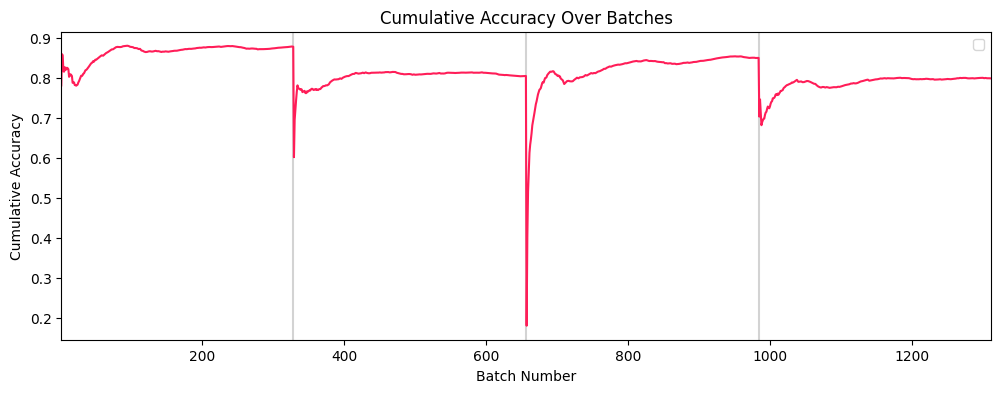

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


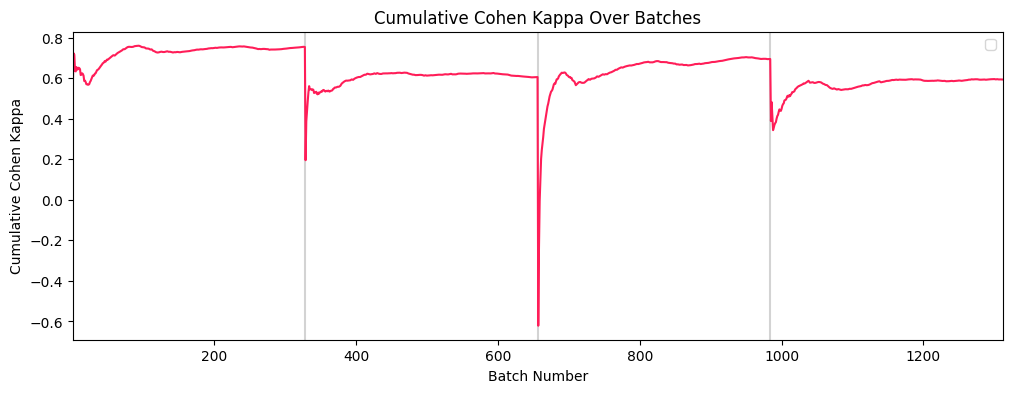

itter 1 finished
list of accuracies that used for evaluating and selecting the models =  [0.8475]
list of kappa values that used for evaluating and selecting the models =  [0.6927783]
index of selcted mask for this task 0
All batches Accuracy=  0.8795743326145152
All batches cohen kappa=  0.755770631997687
list of accuracies that used for evaluating and selecting the models =  [0.73953125 0.775     ]
list of kappa values that used for evaluating and selecting the models =  [0.47510342 0.54482438]
index of selcted mask for this task 1
All batches Accuracy=  0.7940063113474122
All batches cohen kappa=  0.5853763542069894
list of accuracies that used for evaluating and selecting the models =  [0.76640625 0.7659375  0.79484375]
list of kappa values that used for evaluating and selecting the models =  [0.52559515 0.52709797 0.58435339]
index of selcted mask for this task 2
All batches Accuracy=  0.8512296205755503
All batches cohen kappa=  0.6961658406639244
list of accuracies that used for

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


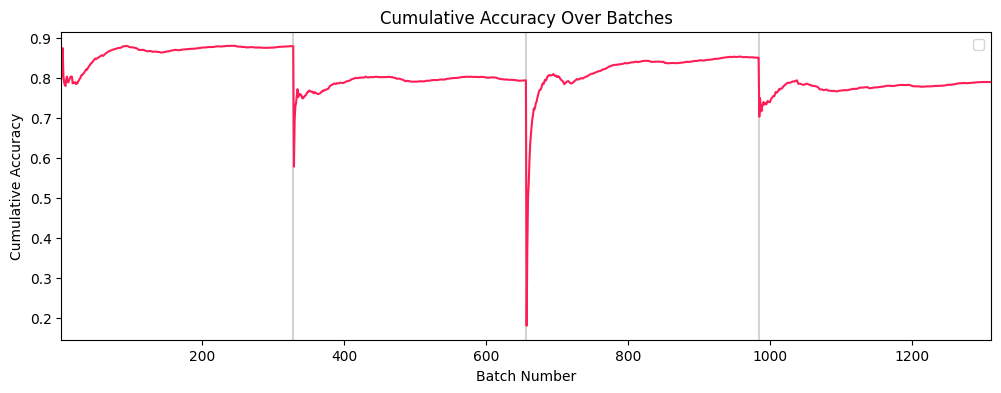

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


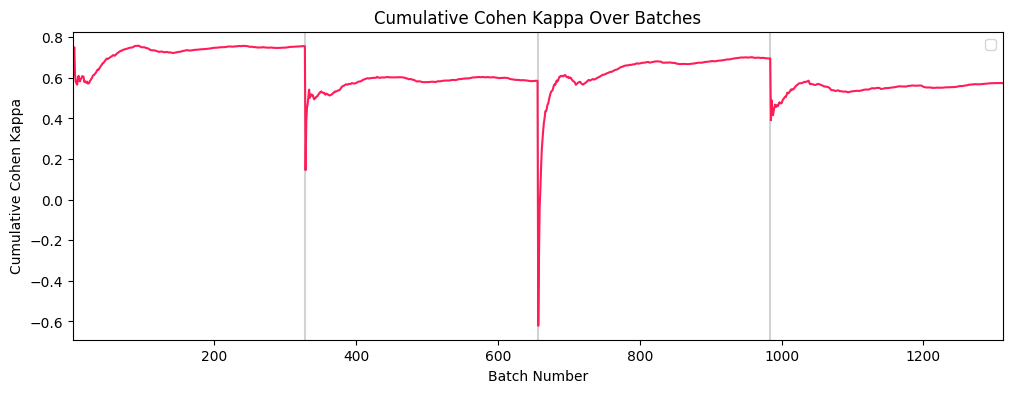

itter 2 finished
list of accuracies that used for evaluating and selecting the models =  [0.84453125]
list of kappa values that used for evaluating and selecting the models =  [0.69028778]
index of selcted mask for this task 0
All batches Accuracy=  0.8763111847486615
All batches cohen kappa=  0.7524997945420626
list of accuracies that used for evaluating and selecting the models =  [0.76390625 0.7878125 ]
list of kappa values that used for evaluating and selecting the models =  [0.52015072 0.56809048]
index of selcted mask for this task 1
All batches Accuracy=  0.7999249423706127
All batches cohen kappa=  0.59641772481363
list of accuracies that used for evaluating and selecting the models =  [0.7634375  0.7465625  0.77578125]
list of kappa values that used for evaluating and selecting the models =  [0.51957572 0.49359291 0.55013628]
index of selcted mask for this task 2
All batches Accuracy=  0.8351108203822128
All batches cohen kappa=  0.6648724780804137
list of accuracies that used

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


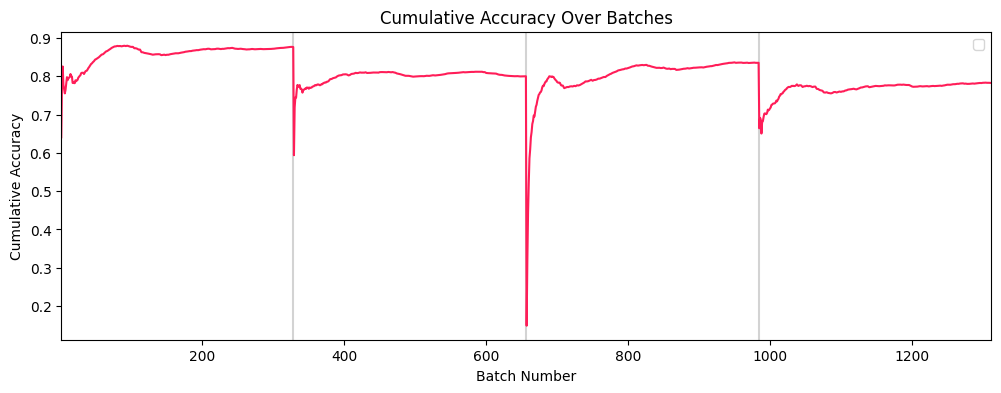

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


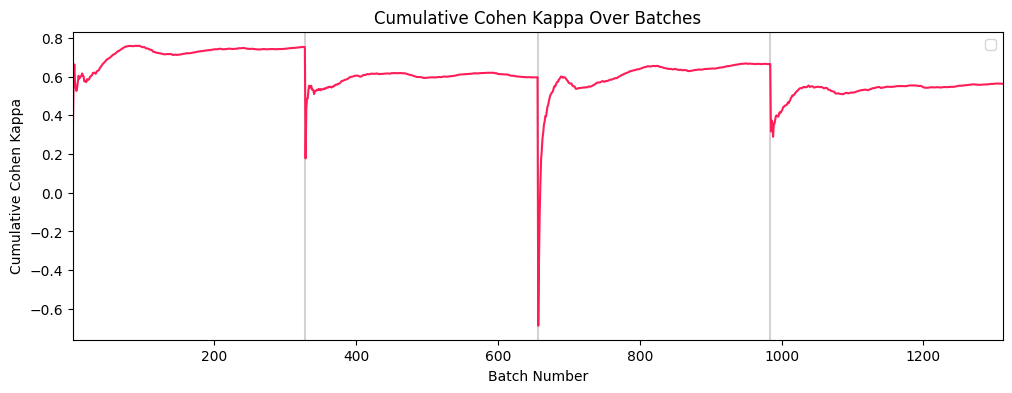

itter 3 finished
list of accuracies that used for evaluating and selecting the models =  [0.848125]
list of kappa values that used for evaluating and selecting the models =  [0.69728036]
index of selcted mask for this task 0
All batches Accuracy=  0.8783415749553836
All batches cohen kappa=  0.7550000818446279
list of accuracies that used for evaluating and selecting the models =  [0.77203125 0.78421875]
list of kappa values that used for evaluating and selecting the models =  [0.53854515 0.56371829]
index of selcted mask for this task 1
All batches Accuracy=  0.8042837457242713
All batches cohen kappa=  0.6041737788970151
list of accuracies that used for evaluating and selecting the models =  [0.755625   0.773125   0.80265625]
list of kappa values that used for evaluating and selecting the models =  [0.50515831 0.54322045 0.59870132]
index of selcted mask for this task 2
All batches Accuracy=  0.8516467365035693
All batches cohen kappa=  0.6982225332091131
list of accuracies that used

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


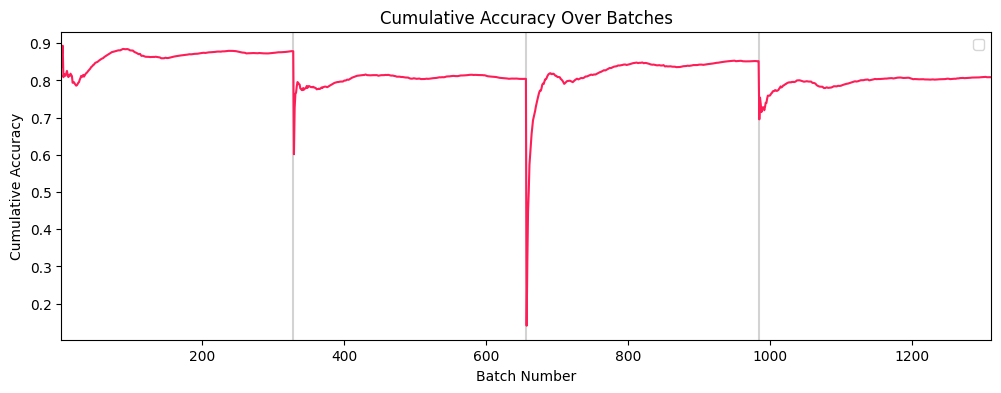

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


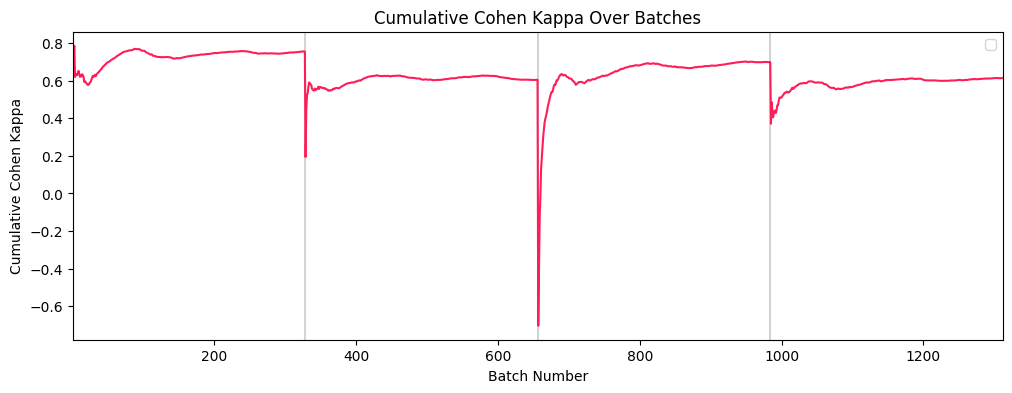

itter 4 finished
list of accuracies that used for evaluating and selecting the models =  [0.84875]
list of kappa values that used for evaluating and selecting the models =  [0.69930275]
index of selcted mask for this task 0
All batches Accuracy=  0.8754298966389055
All batches cohen kappa=  0.7489127111053322
list of accuracies that used for evaluating and selecting the models =  [0.76328125 0.7846875 ]
list of kappa values that used for evaluating and selecting the models =  [0.52073455 0.56288689]
index of selcted mask for this task 1
All batches Accuracy=  0.8061061589083879
All batches cohen kappa=  0.6082599203942752
list of accuracies that used for evaluating and selecting the models =  [0.7809375  0.77203125 0.80265625]
list of kappa values that used for evaluating and selecting the models =  [0.55318151 0.54060813 0.60098248]
index of selcted mask for this task 2
All batches Accuracy=  0.8423098462596668
All batches cohen kappa=  0.6788539764494067
list of accuracies that used 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


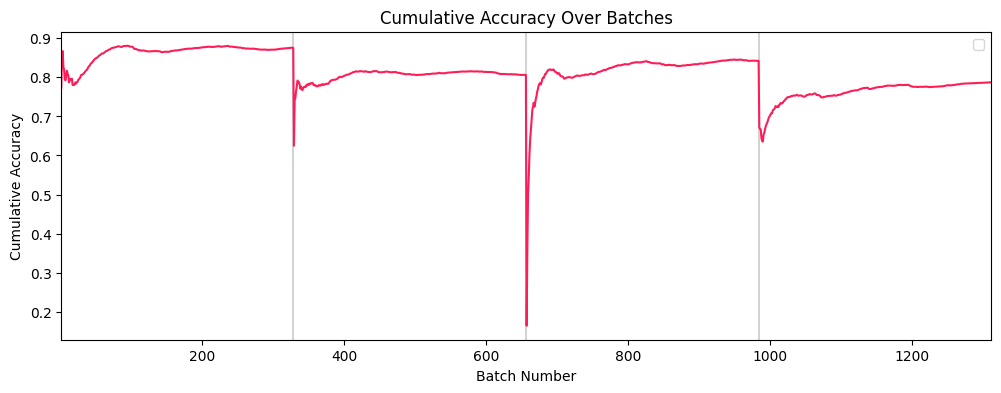

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


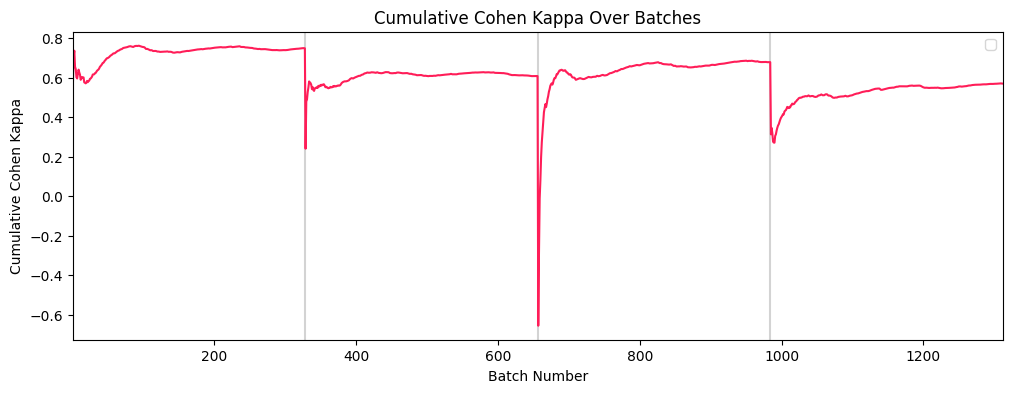

itter 5 finished
list of accuracies that used for evaluating and selecting the models =  [0.84640625]
list of kappa values that used for evaluating and selecting the models =  [0.69364914]
index of selcted mask for this task 0
All batches Accuracy=  0.8786337884815586
All batches cohen kappa=  0.7543215163324665
list of accuracies that used for evaluating and selecting the models =  [0.77265625 0.77921875]
list of kappa values that used for evaluating and selecting the models =  [0.53777498 0.55015881]
index of selcted mask for this task 1
All batches Accuracy=  0.8018484393590125
All batches cohen kappa=  0.5994791957299884
list of accuracies that used for evaluating and selecting the models =  [0.75609375 0.7446875  0.805625  ]
list of kappa values that used for evaluating and selecting the models =  [0.50831001 0.49222109 0.6076992 ]
index of selcted mask for this task 2
All batches Accuracy=  0.8594470367340868
All batches cohen kappa=  0.7120079436543875
list of accuracies that us

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


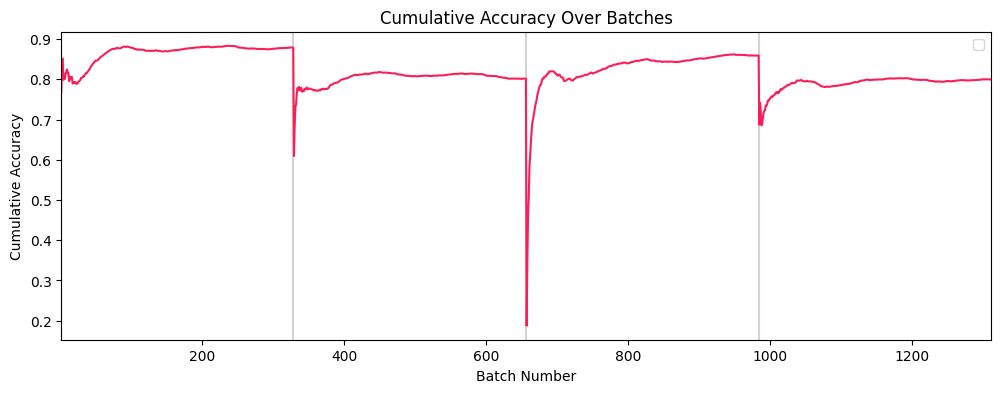

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


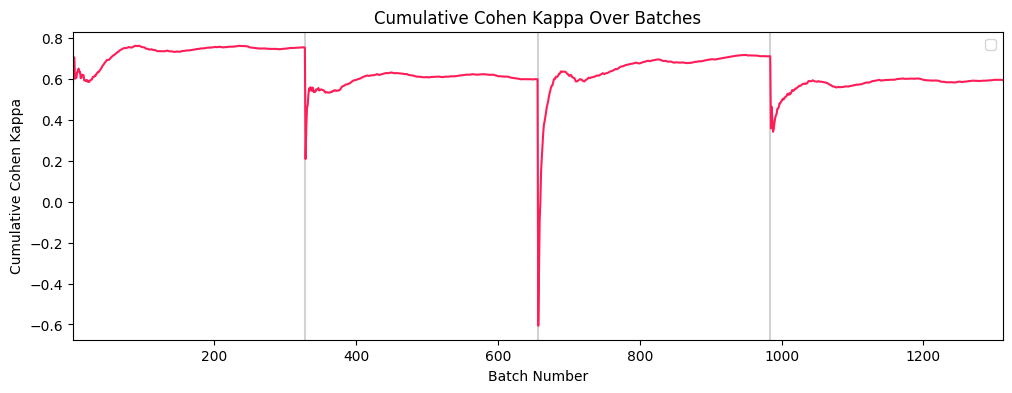

itter 6 finished
list of accuracies that used for evaluating and selecting the models =  [0.85]
list of kappa values that used for evaluating and selecting the models =  [0.69801098]
index of selcted mask for this task 0
All batches Accuracy=  0.8714702000297442
All batches cohen kappa=  0.7408471877527673
list of accuracies that used for evaluating and selecting the models =  [0.75265625 0.77265625]
list of kappa values that used for evaluating and selecting the models =  [0.5034396  0.53865312]
index of selcted mask for this task 1
All batches Accuracy=  0.795441817556514
All batches cohen kappa=  0.5873229040241823
list of accuracies that used for evaluating and selecting the models =  [0.765     0.7534375 0.798125 ]
list of kappa values that used for evaluating and selecting the models =  [0.52693132 0.50595819 0.58984628]
index of selcted mask for this task 2
All batches Accuracy=  0.8529683781975015
All batches cohen kappa=  0.699657136142799
list of accuracies that used for eval

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


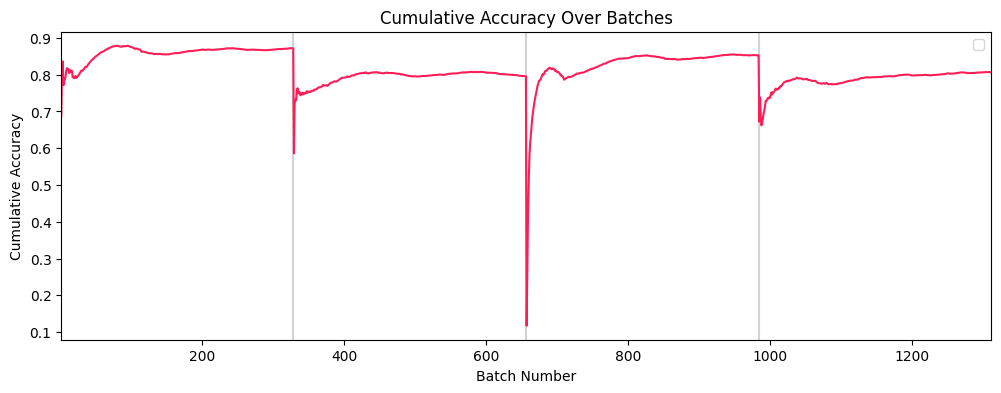

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


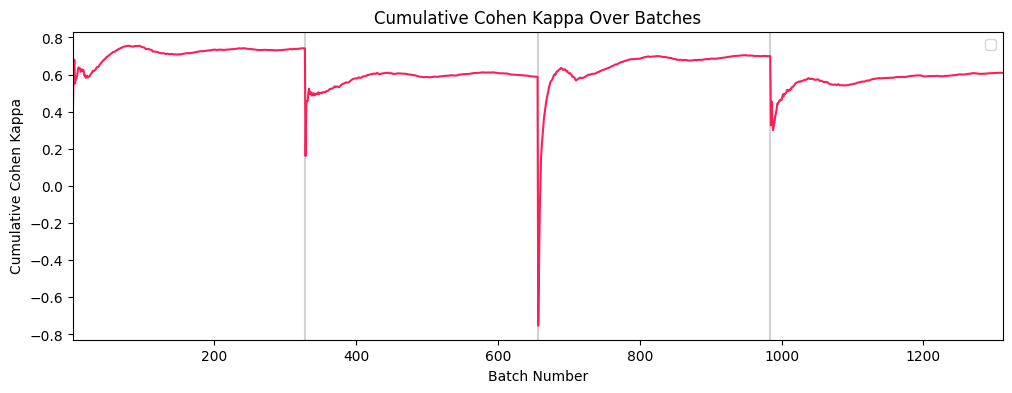

itter 7 finished
list of accuracies that used for evaluating and selecting the models =  [0.8484375]
list of kappa values that used for evaluating and selecting the models =  [0.69851978]
index of selcted mask for this task 0
All batches Accuracy=  0.874614254907793
All batches cohen kappa=  0.7483212801105366
list of accuracies that used for evaluating and selecting the models =  [0.75109375 0.7825    ]
list of kappa values that used for evaluating and selecting the models =  [0.50025895 0.55980827]
index of selcted mask for this task 1
All batches Accuracy=  0.7960186923706127
All batches cohen kappa=  0.5897170838604613
list of accuracies that used for evaluating and selecting the models =  [0.7640625  0.75859375 0.79359375]
list of kappa values that used for evaluating and selecting the models =  [0.52060072 0.51493535 0.58238756]
index of selcted mask for this task 2
All batches Accuracy=  0.8531711267474716
All batches cohen kappa=  0.6995757356763068
list of accuracies that used

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


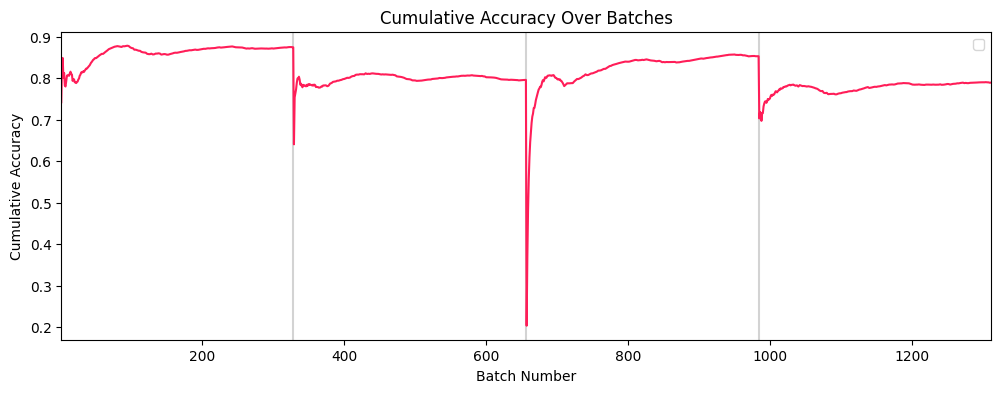

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


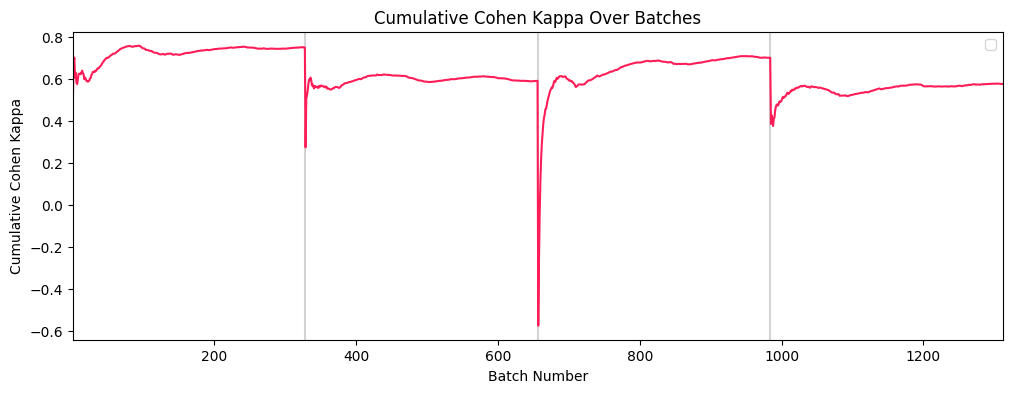

itter 8 finished
list of accuracies that used for evaluating and selecting the models =  [0.84609375]
list of kappa values that used for evaluating and selecting the models =  [0.69305515]
index of selcted mask for this task 0
All batches Accuracy=  0.8766028173334324
All batches cohen kappa=  0.7520078185309724
list of accuracies that used for evaluating and selecting the models =  [0.76453125 0.7696875 ]
list of kappa values that used for evaluating and selecting the models =  [0.52502608 0.53345592]
index of selcted mask for this task 1
All batches Accuracy=  0.7980670917608567
All batches cohen kappa=  0.5918962061405182
list of accuracies that used for evaluating and selecting the models =  [0.7646875  0.761875   0.80171875]
list of kappa values that used for evaluating and selecting the models =  [0.52457968 0.52262844 0.59481599]
index of selcted mask for this task 2
All batches Accuracy=  0.8553798659651993
All batches cohen kappa=  0.7044033545818997
list of accuracies that us

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


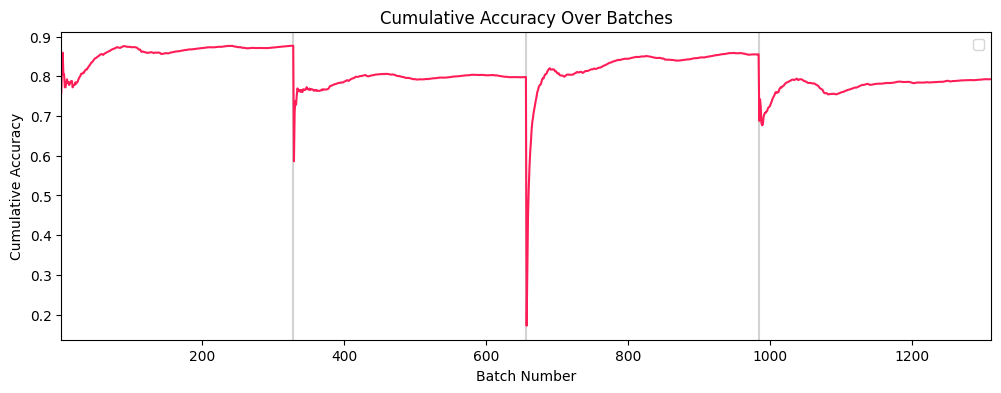

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


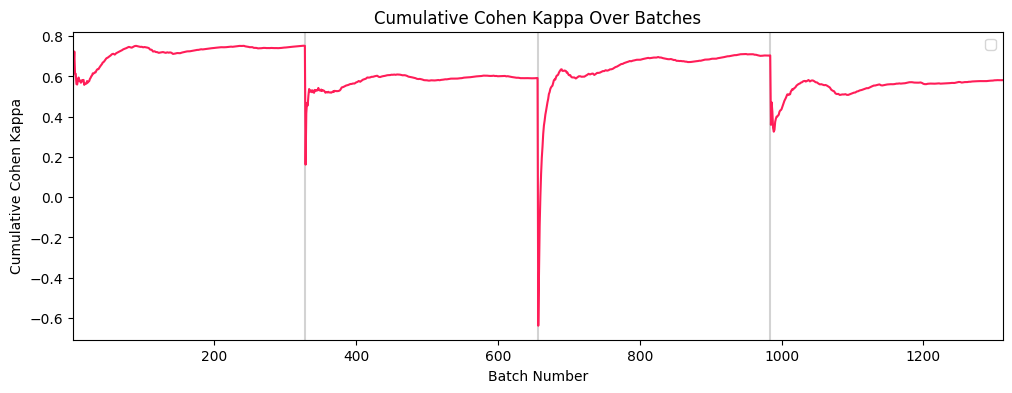

itter 9 finished
list of accuracies that used for evaluating and selecting the models =  [0.84296875]
list of kappa values that used for evaluating and selecting the models =  [0.68600332]
index of selcted mask for this task 0
All batches Accuracy=  0.8721667487730518
All batches cohen kappa=  0.7421951320294927
list of accuracies that used for evaluating and selecting the models =  [0.75375    0.77046875]
list of kappa values that used for evaluating and selecting the models =  [0.50035492 0.53365305]
index of selcted mask for this task 1
All batches Accuracy=  0.7869019789187982
All batches cohen kappa=  0.5709169266245714
list of accuracies that used for evaluating and selecting the models =  [0.76984375 0.77703125 0.8025    ]
list of kappa values that used for evaluating and selecting the models =  [0.53356181 0.54895661 0.59992004]
index of selcted mask for this task 2
All batches Accuracy=  0.8521109086853064
All batches cohen kappa=  0.6966652821794879
list of accuracies that us

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:426: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


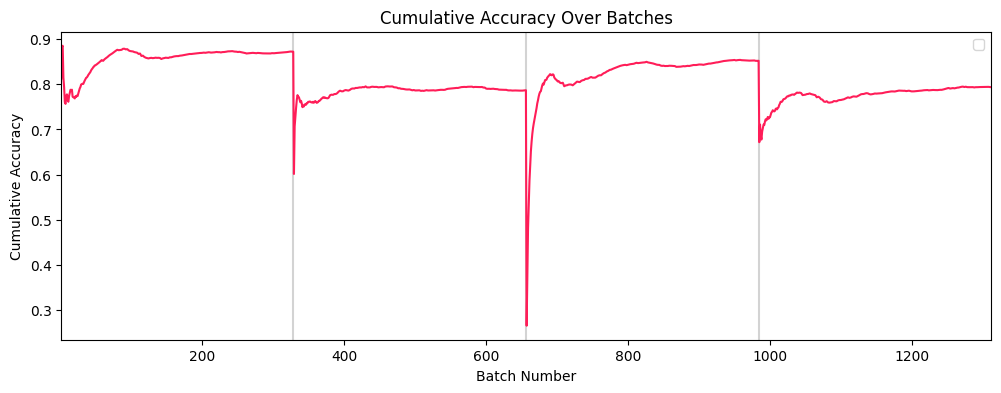

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:443: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


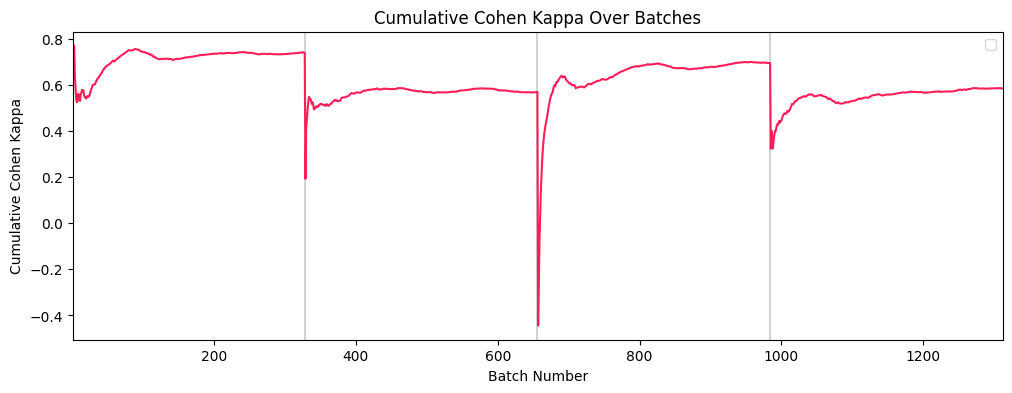

itter 10 finished


In [18]:
for i in range(1,11):
  base_model = 'GRU'
  batch_size = 128
  hidden_size = 150
  seq_len = 11
  epoch_size=10
  lr = 0.01
  number_of_tasks=4
  mask_selection_NofBatch = 50
  input_size=4
  iteration=i
  mask_init='uniform'
  dataset='Weather'
  dataset_name = "weather_st124_3conf"
  Pretrain_task = '1'

  df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
  pretrain_model_addr=f'Performance/Pretrain/{base_model}/{dataset}/After/{dataset}-{base_model}-pretrain-hidden{hidden_size}-epoch10_itter{iteration}.pickle'
  mask_weights=[] #if we have initial masks then reload it here

  mask_option = 'SUM'
  model_type = 'cPB'
  batch_first = True
  low_rank = False


  model = cPB(lr = lr ,hidden_size = hidden_size, seq_len = seq_len,base_model = base_model, pretrain_model_addr = pretrain_model_addr,
            mask_weights = mask_weights, mask_init = mask_init, number_of_tasks = number_of_tasks, epoch_size = epoch_size,
            input_size = input_size, mask_option = mask_option, model_type = model_type, batch_first = batch_first, low_rank = low_rank)


  for iter in range(0,1):
    # loop for each task
    for task in range(1, df["task"].max() + 1):
      df_task = df[df["task"] == task]
      df_task = df_task.drop(columns="task")
      # loop based on each batch of data
      batch_cont=0
      model.weights_copy(task)
      for i in range(0, len(df_task), batch_size):
        x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
        y = list(df_task.iloc[i : i + batch_size, -1])
        if batch_cont<mask_selection_NofBatch:
          for mask_index in range (0, task):
            model.predict_many(x,y,mask_index,task,mask_selection=True)
            model.learn_many(x,y,mask_index)
          batch_cont+=1
        elif batch_cont==mask_selection_NofBatch:
          best_mask_index=model.add_new_column(task)
          model.predict_many(x,y,best_mask_index,task,mask_selection=False)
          model.learn_many(x,y,best_mask_index)
          batch_cont+=1
        elif batch_cont>mask_selection_NofBatch:
          batch_cont+=1
          model.predict_many(x,y,best_mask_index,task,mask_selection=False)
          model.learn_many(x,y,best_mask_index)
      model.save_final_metrics(task,best_mask_index)
      model.final_weights_saving()
    model.plotting()


  file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter{iteration}.pkl'
  with open(file_path, 'wb') as file:
      pickle.dump(model.performance, file)

  file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter{iteration}_selectedMask.pkl'
  with open(file_path, 'wb') as file:
      pickle.dump(model.selected_mask_index, file)
      
      
  file_path=f'Performance/Final Models/{model_type}/{base_model}/{dataset}/{dataset}-{base_model}-pretrain-hidden{hidden_size}-epoch10-Mask_{mask_option}-itter{iteration}.pickle'
  with open(file_path, 'wb') as file:
      pickle.dump(model.all_models_weight, file)
      
  print(f'itter {iteration} finished')



In [4]:
file_1 = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter1.pkl'
with open(file_1, 'rb') as f:
    data1 = pickle.load(f)
    
data1

{'task_1': {'acc': [0.515625,
   0.6484375,
   0.703125,
   0.640625,
   0.703125,
   0.546875,
   0.65625,
   0.6953125,
   0.7578125,
   0.734375,
   0.7421875,
   0.8125,
   0.78125,
   0.6171875,
   0.78125,
   0.703125,
   0.625,
   0.7421875,
   0.8046875,
   0.8359375,
   0.84375,
   0.8046875,
   0.7109375,
   0.8671875,
   0.9140625,
   0.734375,
   0.78125,
   0.796875,
   0.8671875,
   0.7890625,
   0.828125,
   0.7109375,
   0.78125,
   0.7890625,
   0.8515625,
   0.890625,
   0.796875,
   0.765625,
   0.765625,
   0.859375,
   0.8828125,
   0.890625,
   0.8046875,
   0.84375,
   0.890625,
   0.8828125,
   0.828125,
   0.8828125,
   0.8671875,
   0.8125,
   0.8671875,
   0.8671875,
   0.828125,
   0.828125,
   0.875,
   0.875,
   0.7734375,
   0.7734375,
   0.8203125,
   0.8203125,
   0.828125,
   0.828125,
   0.8359375,
   0.8359375,
   0.828125,
   0.828125,
   0.6953125,
   0.6953125,
   0.8046875,
   0.8046875,
   0.8203125,
   0.8203125,
   0.90625,
   0.90625,
   0.87

In [12]:
pretrain_model = GRU_Model(
                input_size=input_size,
                device=torch.device("cpu"),
                num_layers=1,
                hidden_size=50,
                output_size=4,
                batch_size=128,
            )

In [ ]:
list of accuracies that used for evaluating and selecting the models =  [0.77875]
list of kappa values that used for evaluating and selecting the models =  [0.55682867]
index of selcted mask for this task 0
All batches Accuracy=  0.8415888979773944
All batches cohen kappa=  0.6817642093079573
list of accuracies that used for evaluating and selecting the models =  [0.8825     0.78921875]
list of kappa values that used for evaluating and selecting the models =  [0.75827483 0.56541348]
index of selcted mask for this task 0
All batches Accuracy=  0.904547841686496
All batches cohen kappa=  0.8054125549771437
list of accuracies that used for evaluating and selecting the models =  [0.50046875 0.45       0.6865625 ]
list of kappa values that used for evaluating and selecting the models =  [ 0.00623575 -0.09710056  0.36576066]
index of selcted mask for this task 2
All batches Accuracy=  0.7368591054431886
All batches cohen kappa=  0.465597555778137
list of accuracies that used for evaluating and selecting the models =  [0.68984375 0.60890625 0.838125   0.77828125]
list of kappa values that used for evaluating and selecting the models =  [0.38664967 0.22596661 0.68076873 0.56018686]
index of selcted mask for this task 2
All batches Accuracy=  0.8559288555919097
All batches cohen kappa=  0.7082464730866799